In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import re


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [20]:
# Hyperparameters
VOCAB_SIZE = 10000  # Size of vocabulary
EMBEDDING_DIM = 100  # Word embedding dimension
HIDDEN_DIM = 128    # RNN hidden dimension
N_LAYERS = 1        # Number of RNN layers
BATCH_SIZE = 32     
N_EPOCHS = 10        
LEARNING_RATE = 0.001


In [9]:
# 1. Load and preprocess data
df = pd.read_csv("hf://datasets/noob123/imdb_review_3000/imdb_review.csv")

# Simple text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['review'] = df['review'].apply(preprocess_text)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})  # Convert labels to 0/1


In [10]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [11]:
# 2. Build vocabulary
word_counts = Counter()
for text in df['review']:
    word_counts.update(text.split())
    
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(VOCAB_SIZE-2))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# 3. Convert text to sequences
def text_to_seq(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

df['sequence'] = df['review'].apply(text_to_seq)

# 4. Pad sequences
def pad_sequences(sequences, max_len=200):
    padded = np.zeros((len(sequences), max_len))
    for i, seq in enumerate(sequences):
        if len(seq) > max_len:
            padded[i] = seq[:max_len]
        else:
            padded[i,:len(seq)] = seq
    return padded

sequences = pad_sequences(df['sequence'].values)


In [12]:
# 5. Create Dataset
class IMDBDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.sequences[idx]), torch.tensor(self.labels[idx], dtype=torch.float32)


In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(sequences, df['sentiment'].values, test_size=0.2, random_state=42)

train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
# 6. Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # Initialize hidden state
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(device)
        
        # Forward propagate RNN
        out, _ = self.rnn(embedded, h0)  # out: (batch_size, seq_length, hidden_dim)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # (batch_size, output_dim)
        return out.squeeze(1)

model = RNNModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 1, N_LAYERS).to(device)


In [16]:
# 7. Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [17]:
# 8. Training loop
def train(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for batch in loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            preds = torch.round(torch.sigmoid(predictions))
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(loader), accuracy


In [21]:
# Training
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

# Final evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.498
	 Val. Loss: 0.881
	 Val. Acc: 53.17%
Epoch: 02
	Train Loss: 0.450
	 Val. Loss: 0.937
	 Val. Acc: 54.17%
Epoch: 03
	Train Loss: 0.427
	 Val. Loss: 1.087
	 Val. Acc: 49.00%
Epoch: 04
	Train Loss: 0.421
	 Val. Loss: 1.044
	 Val. Acc: 55.00%
Epoch: 05
	Train Loss: 0.411
	 Val. Loss: 1.122
	 Val. Acc: 48.33%
Epoch: 06
	Train Loss: 0.408
	 Val. Loss: 1.098
	 Val. Acc: 47.50%
Epoch: 07
	Train Loss: 0.406
	 Val. Loss: 1.169
	 Val. Acc: 47.67%
Epoch: 08
	Train Loss: 0.724
	 Val. Loss: 0.754
	 Val. Acc: 46.83%
Epoch: 09
	Train Loss: 0.631
	 Val. Loss: 0.742
	 Val. Acc: 52.00%
Epoch: 10
	Train Loss: 0.599
	 Val. Loss: 0.798
	 Val. Acc: 45.50%
Test Loss: 0.798 | Test Acc: 45.50%


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc



In [23]:
# First, get all predictions and true labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs)
            probs = torch.sigmoid(predictions)
            preds = torch.round(probs)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds, all_probs

y_true, y_pred, y_probs = get_predictions(model, test_loader)


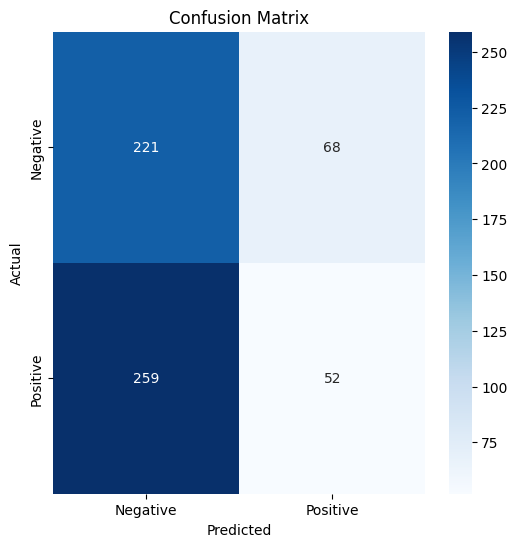

In [24]:
#  Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred)


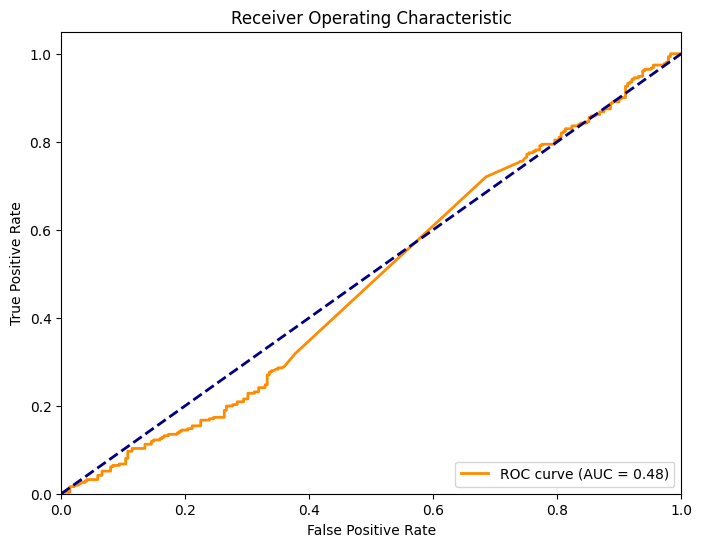

In [27]:
#  ROC Curve
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_true, y_probs)


In [30]:

#  Classification Report
def print_classification_report(y_true, y_pred):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               target_names=['Negative', 'Positive']))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

print_classification_report(y_true, y_pred)




Classification Report:
              precision    recall  f1-score   support

    Negative       0.46      0.76      0.57       289
    Positive       0.43      0.17      0.24       311

    accuracy                           0.46       600
   macro avg       0.45      0.47      0.41       600
weighted avg       0.45      0.46      0.40       600

Accuracy: 0.4550


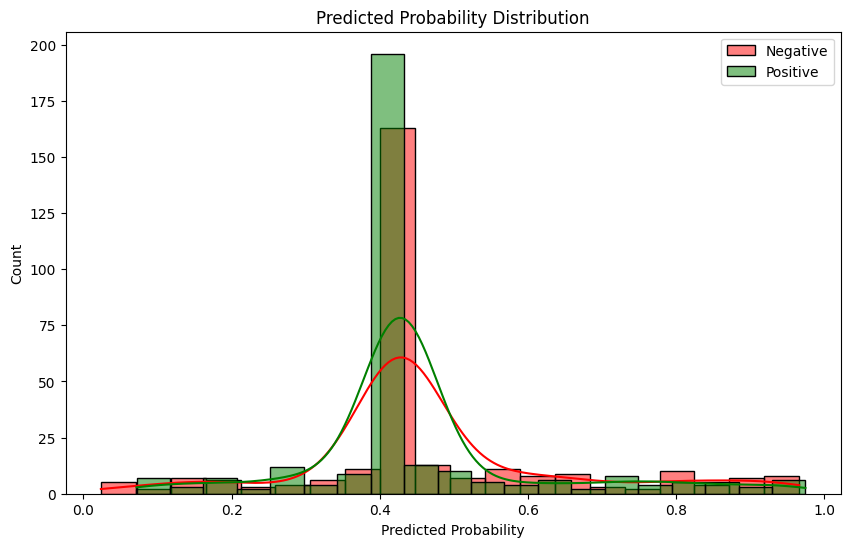

In [29]:
# 4. Probability Distribution (Bonus)
plt.figure(figsize=(10,6))
sns.histplot([y_probs[i] for i in range(len(y_probs)) if y_true[i] == 0], 
             color='red', label='Negative', kde=True, bins=20)
sns.histplot([y_probs[i] for i in range(len(y_probs)) if y_true[i] == 1], 
             color='green', label='Positive', kde=True, bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution')
plt.legend()
plt.show()